## Introduction
This kernel is a simple example of fruit classification with a simple CNN implemented with Keras model and tools. Click the blue "Edit Notebook" or "Fork Notebook" button at the top of this kernel to begin editing.

## General Libs

In [1]:
# General Libs
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory Analysis
Let's view some dataset samples.

This example uses keras ImageDataGenerator. This lib turns easier to read and use image classes from a subdirectoty structure.

### Reading the dataset

In [2]:
im_shape = (250,250)

TRAINING_DIR = '../input/ds_frutas_am/train'
TEST_DIR = '../input/ds_frutas_am/test'

seed = 10

BATCH_SIZE = 16

In [3]:
#Using keras ImageGenerator and flow_from_directoty

# Subdivision in test/validation
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [4]:
# If you want data augmentation, uncomment and run this cell
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
# Generator para parte train
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


### Showing some examples

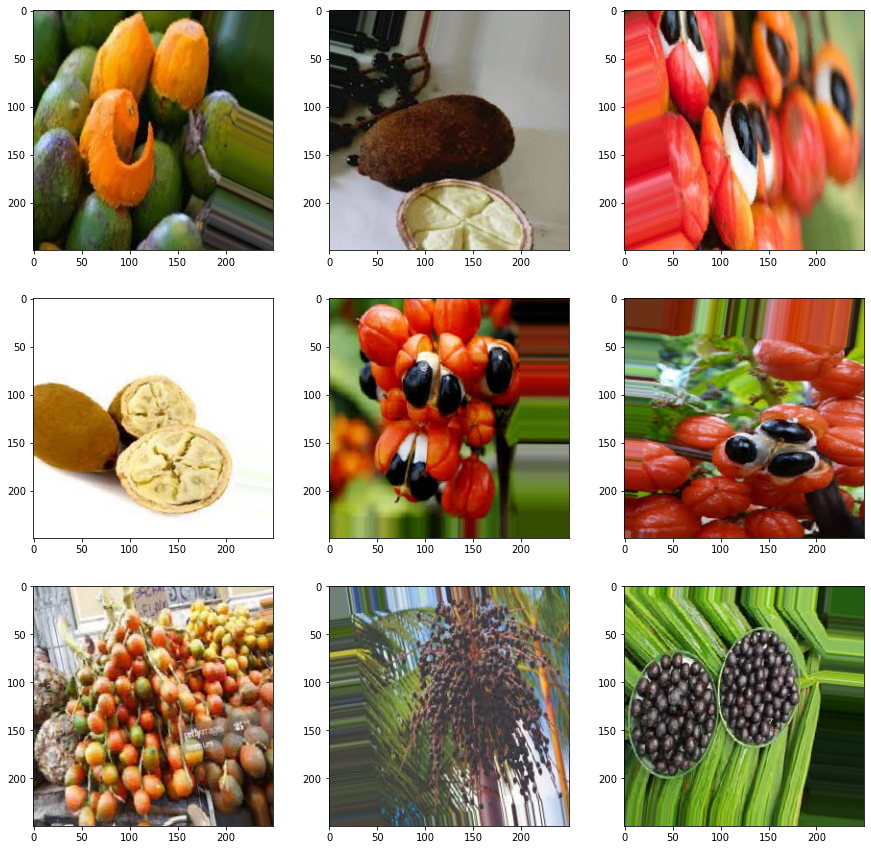

In [6]:
# Visualizing some examples
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

## Creating a simple CNN Model

In [7]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compila o modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 20)      560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 20)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 40)      7240      
_________________________________________________________________
flatten (Flatten)            (None, 595360)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               59536100  
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6

In [8]:
epochs = 80

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/80
4/4 [==============================] - ETA: 0s - loss: 8.0082 - accuracy: 0.3036
Epoch 00001: val_loss improved from inf to 4.88298, saving model to model.h5
4/4 [==============================] - 4s 925ms/step - loss: 8.0082 - accuracy: 0.3036 - val_loss: 4.8830 - val_accuracy: 0.3125
Epoch 2/80
4/4 [==============================] - ETA: 0s - loss: 4.2279 - accuracy: 0.2679
Epoch 00002: val_loss improved from 4.88298 to 2.53724, saving model to model.h5
4/4 [==============================] - 4s 942ms/step - loss: 4.2279 - accuracy: 0.2679 - val_loss: 2.5372 - val_accuracy: 0.1875
Epoch 3/80
4/4 [==============================] - ETA: 0s - loss: 2.8090 - accuracy: 0.2679
Epoch 00003: val_loss improved from 2.53724 to 1.92393, saving model to model.h5
4/4 [==============================] - 6s 2s/step - loss: 2.8090 - accuracy: 0.2679 - val_loss: 1.9239 - val_accuracy: 0.4375
Epoch 4/80
4/4 [==============================] - ETA: 0s - loss: 1.6402 - accuracy: 0.4286
Epoch 000

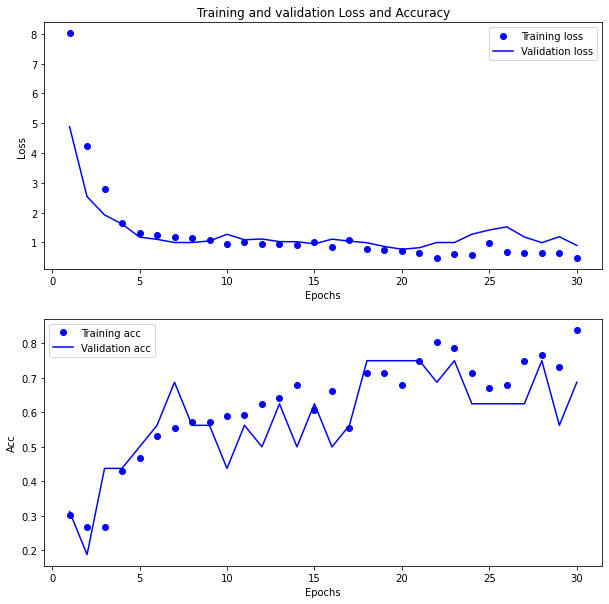

In [9]:
# Training curves
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Evaluating the model

In [10]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [11]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.806879460811615
Val accuracy: 0.7222222089767456


In [12]:
# Using the test dataset
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.744477391242981
Test accuracy: 0.7333333492279053


In [13]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Classification Report
              precision    recall  f1-score   support

        acai       0.83      1.00      0.91         5
     cupuacu       0.67      0.40      0.50         5
    graviola       0.56      1.00      0.71         5
     guarana       0.83      1.00      0.91         5
     pupunha       0.80      0.80      0.80         5
      tucuma       1.00      0.20      0.33         5

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.69        30
weighted avg       0.78      0.73      0.69        30



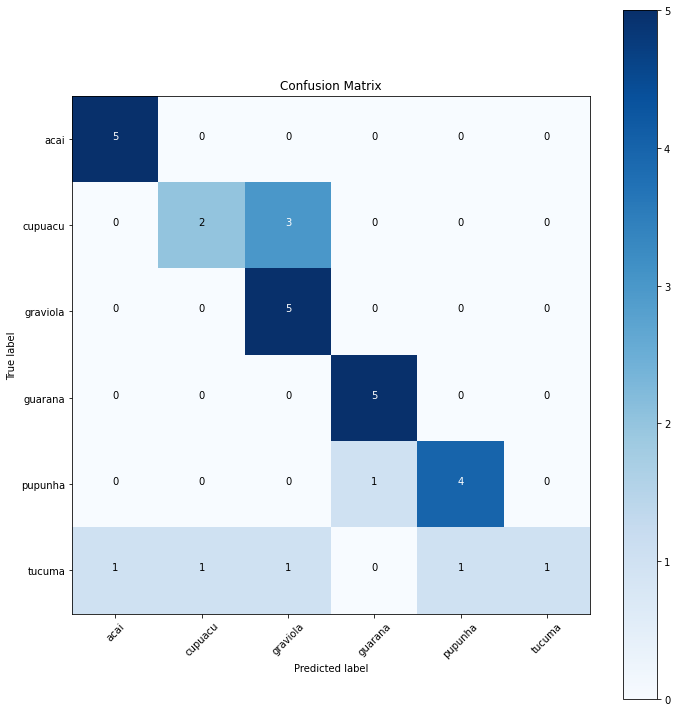

In [14]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#On test dataset
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))